# Hysteresis Loops Fitting with Tensorflow

In [1]:
import sys
sys.path.append('../../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import time
import os

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Activation, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from scipy.signal import resample
from sklearn.preprocessing import StandardScaler

from matplotlib.patches import ConnectionPatch

from src.m3_learning.optimizers.TRPCGOptimizerv2 import TRPCGOptimizerv2
from src.m3_learning.be.processing import loop_lsqf, loop_fitting_function, loop_fitting_function_tf
from src.m3_learning.be.filters import clean_interpolate
from src.m3_learning.nn.random import random_seed
from src.m3_learning.util.preprocessing import global_scaler

## Loads data

In [4]:
# Sets path to file
path = r"./"

# Opens the data file
h5_f = h5py.File(path + "data_file.h5", "r+")

# number of pixels in the image
num_pix = h5_f["Measurement_000"].attrs["num_pix"]

num_pix_1d = int(np.sqrt(num_pix))

# extracting spectroscopic values
spectroscopic_values = h5_f['Measurement_000']['Channel_000']['Spectroscopic_Values']

proj_nd_shifted = loop_lsqf(h5_f)

# getting parameters for the hysteresis loops
params = np.zeros((num_pix, 9))
params_names = ['a_0', 'a_1', 'a_2', 'a_3', 'a_4', 'b_0', 'b_1', 'b_2', 'b_3']

for i in range(9):
  params[:, i] = np.array(h5_f['Measurement_000']['Channel_000']['Raw_Data-SHO_Fit_000']['Guess-Loop_Fit_000']['Fit'][params_names[i]][:, 3])

# voltage vector
V = np.swapaxes(np.atleast_2d(h5_f['Measurement_000']['Channel_000']['UDVS'][::2][:, 1][24:120]), 0, 1).astype(np.float64)

# to set up a type of loop_fitting function to use. Possible options: ['9 parameters', '13 parameters']
func_type = '9 parameters'

# creating fits from fitting function and preparing for visualization
loop_fit_results = np.reshape(loop_fitting_function(func_type, V, params), (96, num_pix_1d, num_pix_1d))
proj_nd_shifted_transposed = np.transpose(proj_nd_shifted,(1,0,2,3))

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Channel_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


## Dataset exploration

### Visualizes data of the waveform and a single loop

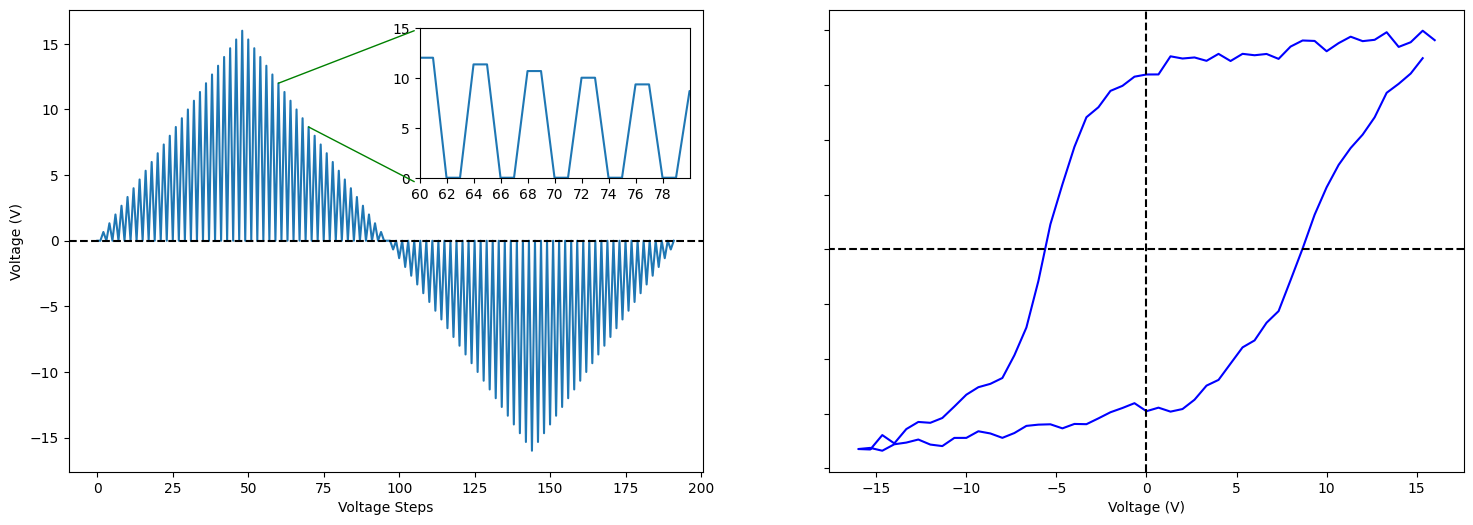

In [5]:
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=2)
hysteresis_waveform = spectroscopic_values[1, ::165][192:] * spectroscopic_values[2, ::165][192:]
x_start = 120
x_end = 140

axs[0].plot(hysteresis_waveform)
ax_new = fig.add_axes([0.32, 0.6, 0.15, 0.25])
ax_new.plot(np.repeat(hysteresis_waveform, 2))
ax_new.set_xlim(x_start, x_end)
ax_new.set_ylim(0, 15)
ax_new.set_xticks(np.arange(x_start, x_end, 2))
ax_new.set_xticklabels([60, 62, 64, 66, 68, 70, 72, 74, 76, 78]) 
fig.add_artist(ConnectionPatch(xyA=(x_start//2, hysteresis_waveform[x_start//2]), coordsA=axs[0].transData, xyB=(105, 16), coordsB=axs[0].transData, color='green'))
fig.add_artist(ConnectionPatch(xyA=(x_end//2, hysteresis_waveform[x_end//2]), coordsA=axs[0].transData, xyB=(105, 4.5), coordsB=axs[0].transData, color='green'))
axs[0].set_xlabel('Voltage Steps')
axs[0].set_ylabel('Voltage (V)')

i = np.random.randint(0,num_pix_1d,2)
axs[1].plot(V, proj_nd_shifted_transposed[i[0], i[1], :, 3],'blue')
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')
axs[1].label_outer()

axs[0].axhline(y=0, xmax=200, linestyle='--', color='black')
axs[1].axhline(y=0, xmin=-16, xmax=16, linestyle='--', color='black')
axs[1].axvline(x=0, linestyle='--', color='black')

plt.savefig('Assets/Figures/hysteresis_waveform_stacked.png', bbox_inches='tight', pad_inches=1)
plt.savefig('Assets/Figures/hysteresis_waveform_stacked.svg', bbox_inches='tight', pad_inches=1)

### Checks Tensoflow version of fitting function

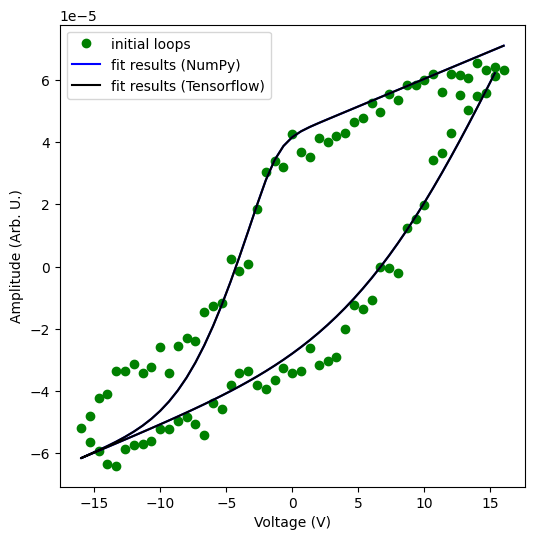

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
i = np.random.randint(0,num_pix_1d,2)
axs.plot(V, proj_nd_shifted_transposed[i[0], i[1], :, 3],'og',
         label='initial loops')
axs.plot(V, loop_fit_results[:, i[0], i[1]], 'blue', label='fit results (NumPy)')
axs.plot(V, np.reshape(loop_fitting_function_tf(func_type, V, params), 
                       (num_pix_1d, num_pix_1d, 96))[i[0], i[1], :], 'black', 
         label='fit results (Tensorflow)')
axs.legend()
axs.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs.set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)')
axs.label_outer()

### Preprocesses data

In [7]:
real_loops = clean_interpolate(proj_nd_shifted_transposed[:, :, :, 3].reshape(num_pix,-1)).astype(np.float64)
real_loops_scaler = global_scaler()
real_scaled_loops = real_loops_scaler.fit_transform(real_loops).astype(np.float64)

real_parms_scaler = StandardScaler()
real_parms_scaled = real_parms_scaler.fit_transform(params)

# getting mean and std of parameters
params_mean = real_parms_scaler.mean_
params_std = np.sqrt(real_parms_scaler.var_)

data_mean = real_loops_scaler.mean.astype(np.float64)
data_std = real_loops_scaler.std.astype(np.float64)

In [ ]:
# save the data into a file
h5_f.create_dataset("params_hysteresis", data=params)
h5_f.create_dataset("real_loops_hysteresis", data=real_loops)

### Checks the emperical function

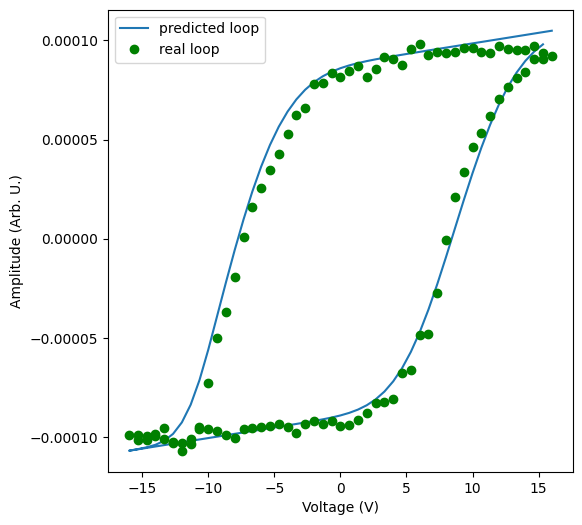

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
n = np.random.randint(0,num_pix)

params_ = real_parms_scaler.inverse_transform(real_parms_scaled[n].reshape(1, -1))
loop_pred = loop_fitting_function_tf(func_type, V, np.atleast_2d(params_))

axs.plot(V, np.asarray(loop_pred[0]), label='predicted loop')
axs.plot(V, real_loops[n],'og', label='real loop')
axs.set(xlabel='Voltage (V)', ylabel='Amplitude (Arb. U.)');
axs.legend();
axs.label_outer()

### Visualizes each parameter

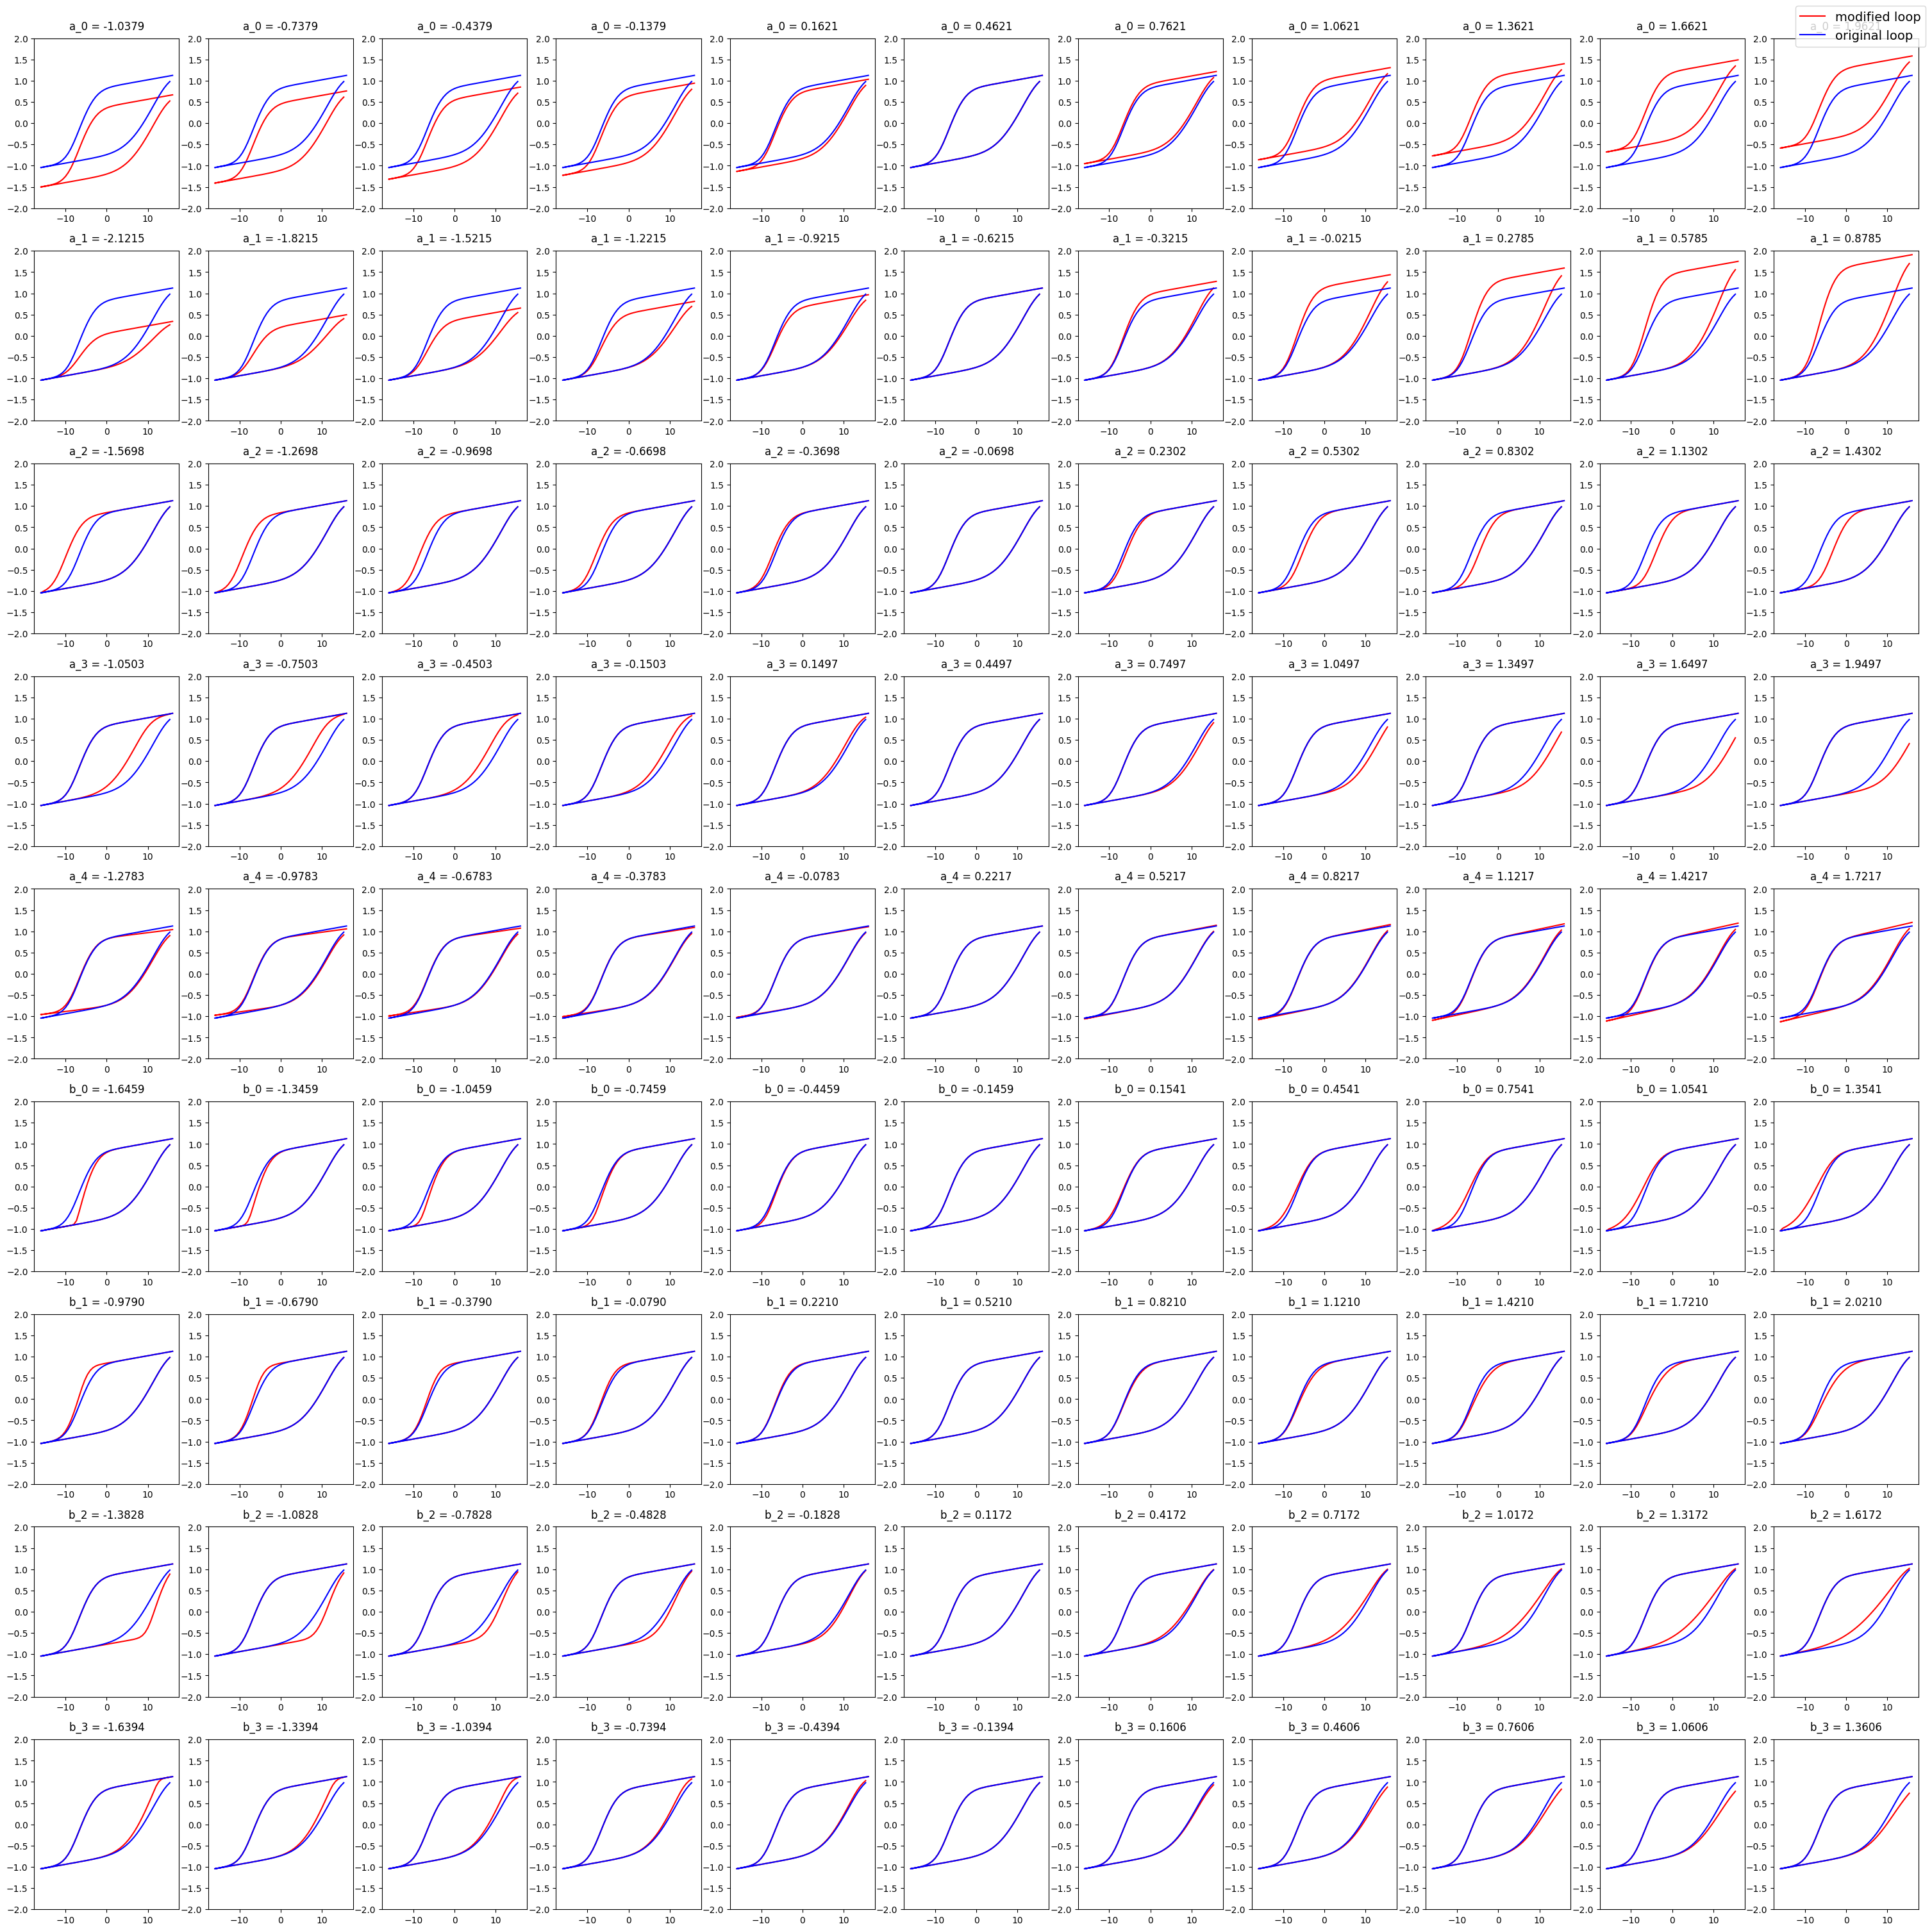

In [10]:
fig, axs = plt.subplots(9, 11, figsize=(30, 30))

changes_scaled = np.arange(-1.5, 1.8, 0.3)

for param_idx in range(params.shape[1]):
  mean_parm_idx = np.where((np.mean(real_scaled_loops, axis=1) > -0.0001) & (np.mean(real_scaled_loops, axis=1) < 0.0001))[0][0]
  axs[param_idx, 5].plot(V, tf.divide(tf.subtract(tf.transpose(loop_fitting_function_tf(func_type, V, np.atleast_2d(params[mean_parm_idx]))), tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std)), color='red', label='modified loop')
  axs[param_idx, 5].plot(V, tf.divide(tf.subtract(tf.transpose(loop_fitting_function_tf(func_type, V, np.atleast_2d(params[mean_parm_idx]))), tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std)), color='blue', label='original loop')
  axs[param_idx, 5].grid(False)
  axs[param_idx, 5].set_title(f'{params_names[param_idx]} = {float(real_parms_scaled[mean_parm_idx, param_idx]):.4f}', pad=10)
  
  for change_level in range(1, 6):
    modified_params_neg = params.copy()
    modified_params_pos = params.copy()
    modified_params_scaled_neg = real_parms_scaled.copy()
    modified_params_scaled_pos = real_parms_scaled.copy()
    change_scaled_neg = changes_scaled[5-change_level]
    change_scaled_pos = changes_scaled[5+change_level]
    modified_params_scaled_neg[:, param_idx] += change_scaled_neg
    modified_params_scaled_pos[:, param_idx] += change_scaled_pos

    modified_params_neg[:, param_idx] = (modified_params_scaled_neg[:, param_idx] * params_std[param_idx]) + params_mean[param_idx]
    modified_params_pos[:, param_idx] = (modified_params_scaled_pos[:, param_idx] * params_std[param_idx]) + params_mean[param_idx]

    if param_idx == 0 and 5-change_level == 4:
      lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
      lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

    axs[param_idx, 5-change_level].plot(V, tf.divide(tf.subtract(tf.transpose(loop_fitting_function_tf(func_type, V, np.atleast_2d(modified_params_neg[mean_parm_idx]))), tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std)), color='red', label='modified loop')
    axs[param_idx, 5-change_level].plot(V, tf.divide(tf.subtract(tf.transpose(loop_fitting_function_tf(func_type, V, np.atleast_2d(params[mean_parm_idx]))), tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std)), color='blue', label='original loop')
    axs[param_idx, 5-change_level].grid(False)
    axs[param_idx, 5-change_level].set_title(f'{params_names[param_idx]} = {float(modified_params_scaled_neg[mean_parm_idx, param_idx]):.4f}', pad=10)

    axs[param_idx, 5+change_level].plot(V, tf.divide(tf.subtract(tf.transpose(loop_fitting_function_tf(func_type, V, np.atleast_2d(modified_params_pos[mean_parm_idx]))), tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std)), color='red', label='modified loop')
    axs[param_idx, 5+change_level].plot(V, tf.divide(tf.subtract(tf.transpose(loop_fitting_function_tf(func_type, V, np.atleast_2d(params[mean_parm_idx]))), tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std)), color='blue', label='original loop')
    axs[param_idx, 5+change_level].grid(False)
    axs[param_idx, 5+change_level].set_title(f'{params_names[param_idx]} = {float(modified_params_scaled_pos[mean_parm_idx, param_idx]):.4f}', pad=10)

plt.setp(axs, ylim=[-2.0, 2.0])
fig.tight_layout()
plt.legend(lines, labels, bbox_to_anchor=(1.05, 11.2), loc='upper right', borderaxespad=0., prop={'size': 14})
plt.savefig('Assets/Figures/hysteresis_params_meaning.png', bbox_inches='tight')
plt.savefig('Assets/Figures/hysteresis_params_meaning.svg', bbox_inches='tight')

## Tensorflow model

### Model Architecture

![](Assets\Figures\model_architecture_hysteresis.png)

In [11]:
ACTIVATION = tf.nn.leaky_relu

def Conv1D_Block(X, time_step, kernel_size):
    x = Conv1D(time_step, kernel_size, padding='same')(X)
    x = Activation(ACTIVATION)(x)      
    return x

def Conv1D_Pie(kernel_size = 3, n_step = 96):
    X_input = Input(shape=(n_step, 1))
    x = X_input
    
    x = Conv1D_Block(x, 16, kernel_size)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D_Block(x, 32, kernel_size)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D_Block(x, 16, kernel_size)
    x = MaxPooling1D(2, padding='same')(x)
    
    time_step = 8 
    
    x = Conv1D_Block(x, time_step, kernel_size)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D_Block(x, time_step, kernel_size)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D_Block(x, time_step, kernel_size)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D_Block(x, time_step, kernel_size)
    x = MaxPooling1D(2, padding='same')(x)
    
    encoded = Flatten()(x)
    
    embedding = Dense(9, activation='linear')(encoded)
    embedding = tf.cast(embedding, dtype='float64')
    
    unscaled_param = tf.add(tf.multiply(embedding, tf.convert_to_tensor(params_std)),\
                            tf.convert_to_tensor(params_mean))
    scaled_loops = tf.divide(tf.subtract(loop_fitting_function_tf(func_type, V, unscaled_param), \
                            tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std))

    model = Model(X_input, scaled_loops, name = 'Convolutional_1D')
    
    return model

In [12]:
model = Conv1D_Pie()
model.summary()

Model: "Convolutional_1D"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 96, 16)       64          ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 96, 16)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 48, 16)       0           ['activation[0][0]']             
                                                                                   

In [13]:
for i,l in enumerate(model.layers):
    print(i,l)

0 <keras.engine.input_layer.InputLayer object at 0x000002C6F1D57D90>
1 <keras.layers.convolutional.conv1d.Conv1D object at 0x000002C6F1D55900>
2 <keras.layers.core.activation.Activation object at 0x000002C6608B2FB0>
3 <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x000002C6608B1030>
4 <keras.layers.convolutional.conv1d.Conv1D object at 0x000002C6F1D55CC0>
5 <keras.layers.core.activation.Activation object at 0x000002C6F1D577F0>
6 <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x000002C6F1D54760>
7 <keras.layers.convolutional.conv1d.Conv1D object at 0x000002C6F1D54790>
8 <keras.layers.core.activation.Activation object at 0x000002C6F1CB0400>
9 <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x000002C6F1D2FD60>
10 <keras.layers.convolutional.conv1d.Conv1D object at 0x000002C6F1D2CBB0>
11 <keras.layers.core.activation.Activation object at 0x000002C6F15AB700>
12 <keras.layers.pooling.max_pooling1d.MaxPooling1D object at 0x000002C6F1CB04F0>
13 <keras.layers

### Extracting the intermediate layer (before the emperial function)

In [14]:
random_seed(seed=42)
tf.keras.backend.set_floatx('float64')

model = Conv1D_Pie()
model.compile(optimizer=Adam(0.00001), loss='mse')
FVAL = []

# getting intermediate layer
earlyPredictor = tf.keras.Model(model.inputs, model.layers[23].output)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


### Model training with Trust-Region CG optimizer

In [15]:
random_seed(seed=42)

cgopttol = 1e-7
c0tr = 0.2
c1tr = 0.25
c2tr = 0.75  # when to accept
t1tr = 0.75
t2tr = 2.0
radius_max = 5.0  # max radius
radius_initial = 1.0
radius = radius_initial

optimizer = TRPCGOptimizerv2(model, radius_initial, 0)
print("d = ", optimizer.d)
allsamples=[i for i in range(num_pix)]

st = time.time()

for epoch in range(1000):

    np.random.shuffle(allsamples)
    BS = 100

    for it in range(num_pix//BS):

      # dividing into batches
      x = real_scaled_loops[allsamples[it*BS:(it+1)*BS]]
      y = real_scaled_loops[allsamples[it*BS:(it+1)*BS]]

      # model optimization
      loss, d, rho, update, cg_iter, cg_term, loss_grad, norm_d, numerator, denominator, rad = \
      optimizer.step(x,y)
      
      # predicting the intermediate layer and passing to empirical function
      parm_pred = earlyPredictor.predict(real_scaled_loops)
      embedding = parm_pred
      unscaled_param = tf.add(tf.multiply(embedding, tf.convert_to_tensor(params_std)),\
                          tf.convert_to_tensor(params_mean))
      scaled_loops_DNN = tf.divide(tf.subtract(loop_fitting_function_tf(func_type, V, unscaled_param), \
                          tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std))

      # calculating the reconstruction loss
      err = tf.reduce_mean(tf.abs(scaled_loops_DNN - real_scaled_loops)).numpy()
      FVAL.append([loss.numpy(), err])
      print(epoch, time.time()-st, "sec", FVAL[-1], cg_iter, optimizer.radius)
      
      if(optimizer.radius < 1e-15):
          break

    # train for 5 minutes
    if(time.time() - st > 300):
        break

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
d =  4257
rejecting .... radius: 2.500000e-01   FVALNew 7.921694e-02,  DeltaF -1.751440e-01 
rejecting .... radius: 6.250000e-02   FVALNew 7.921694e-02,  DeltaF -7.542128e-03 
113/113 [==============================] - 2s 8ms/step
0 20.542434692382812 sec [0.0792169397031171, 0.24052466185863153] 1 0.0625
113/113 [==============================] - 1s 6ms/step
0 21.995692491531372 sec [0.08709663144252966, 0.2401254241475459] 2 0.0625
113/113 [==============================] - 1s 8ms/step
0 24.13454556465149 sec [0.09466823136346816, 0.24019921762338506] 1 0.0625
113/113 [==============================] - 1s 9ms/step
0 26.255037784576416 sec [0.0793840305924678, 0.23952761901131558] 1 0.125
113/113 [==============================] - 1s 8ms/step
0 28.01463794708252 sec [0.08889692559612307, 0.24120258096914685] 2 0.125
113/113 [==============================] - 1s 9ms/step
0 29.85362672805786 sec [0.0769410

### Visualizes the training loss

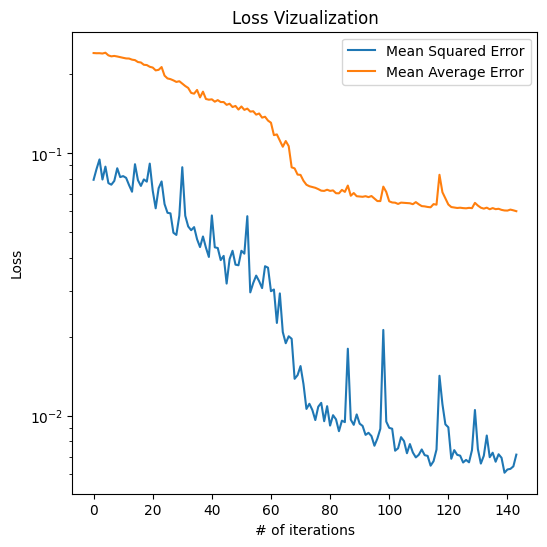

In [16]:
# array with loss
FVAL_numpy = np.asarray(FVAL)

# loss vizualization
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

axs.semilogy(np.array(FVAL_numpy[:, 0]), label='Mean Squared Error') 
axs.semilogy(np.array(FVAL_numpy[:, 1]), label='Mean Average Error')
axs.set(xlabel='# of iterations', ylabel='Loss')
axs.set_title('Loss Vizualization')
axs.legend()
axs.label_outer()

### Saves the model and results

In [17]:
# saving the model
model.save('./Trained Models/Loops')

# saving predictions
unscaled_param_trust = tf.identity(unscaled_param)
scaled_params_trust = tf.identity(embedding)

# save the predictions into a file
h5_f.create_dataset("predictions_hysteresis_trustregcg", data=unscaled_param_trust.numpy())

INFO:tensorflow:Assets written to: ./Trained Models/Loops\assets


INFO:tensorflow:Assets written to: ./Trained Models/Loops\assets


### Model training with Adam optimizer

In [18]:
# training model with Adam optimizer
random_seed(seed=42)
model = Conv1D_Pie()
model.compile(Adam(3e-5), loss='mse')
model.fit(real_scaled_loops, real_scaled_loops, batch_size=1200, epochs=1000)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42
Epoch 1/1000
3/3 [==============================] - 8s 115ms/step - loss: 0.0910
Epoch 2/1000
3/3 [==============================] - 0s 103ms/step - loss: 0.0909
Epoch 3/1000
3/3 [==============================] - 0s 101ms/step - loss: 0.0909
Epoch 4/1000
3/3 [==============================] - 0s 96ms/step - loss: 0.0908
Epoch 5/1000
3/3 [==============================] - 0s 99ms/step - loss: 0.0907
Epoch 6/1000
3/3 [==============================] - 0s 92ms/step - loss: 0.0907
Epoch 7/1000
3/3 [==============================] - 0s 105ms/step - loss: 0.0906
Epoch 8/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.0905
Epoch 9/1000
3/3 [==============================] - 0s 102ms/step - loss: 0.0905
Epoch 10/1000
3/3 [==============================] - 0s 110ms/step - loss: 0.0904
Epoch 11/1000
3/3 [==============================] - 0s 110ms/step - loss: 0.0904
Epoch 12/1000
3/3 [=========

### Saves the results

In [19]:
# predicting the intermediate layer and passing to empirical function
earlyPredictor = tf.keras.Model(model.inputs,model.layers[23].output)
parm_pred = earlyPredictor.predict(real_scaled_loops)
embedding = parm_pred

unscaled_param = tf.add(tf.multiply(embedding, tf.convert_to_tensor(params_std)),\
                    tf.convert_to_tensor(params_mean))
scaled_loops_DNN = tf.divide(tf.subtract(loop_fitting_function_tf(func_type, V, unscaled_param), \
                    tf.convert_to_tensor(data_mean)), tf.convert_to_tensor(data_std))

# save the predictions into a file
h5_f.create_dataset("predictions_hysteresis_adam", data=unscaled_param.numpy())

113/113 [==============================] - 2s 10ms/step


<HDF5 dataset "predictions_hysteresis_adam": shape (3600, 9), type "<f8">

In [20]:
h5_f.close()